# Flow over a cylinder with source-panels

In [3]:
import numpy
import math
from matplotlib import pyplot
from scipy import integrate
%matplotlib inline

In [4]:
u_inf = 1.0

We know that we can get the flow around a cylider by superposing a doublet in a free stream, but here we want to develop a more general approach that can later be extended to different shapes

The method we will use consists of representing the geometry of the body by a series of short linear segments, called panels, that correspond to source sheets like we studied in the previous lesson.

What we are aiming for is a method that starts with a defined body geometry, then works out the strength of sources needed in each panel representing that geometry to get a dividing streamline right on the body boundary. We will have to solve for the source strengths by specifying that the body be a streamline, i.e., the velocity be tangent there.


# Definition of the geometry

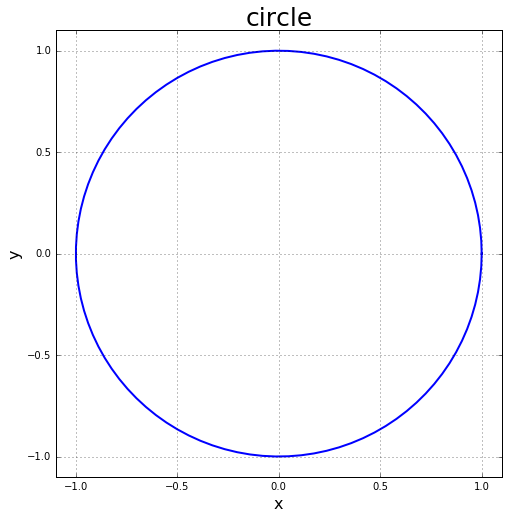

In [5]:
R = 1.0
theta = numpy.linspace(0, 2*math.pi, 100)
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)

size = 8
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);
pyplot.title('circle', fontsize=25)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)


# Discretization into panels

In [6]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2               # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(ya-yb)**2)         # length of the panel
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient
    
    
        

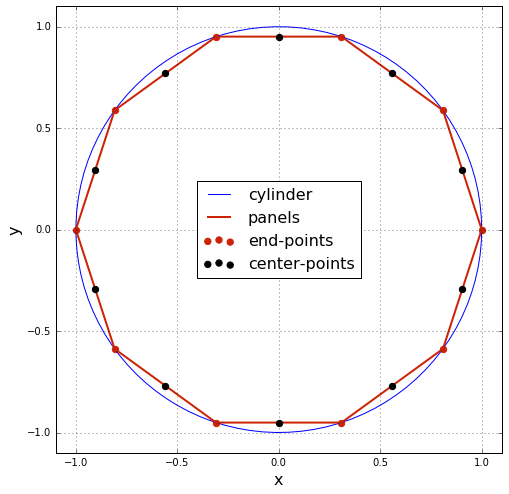

In [7]:
N_panels = 10     # number of panels desired

#define the end_points of the panels
x_ends = R*numpy.cos(numpy.linspace(0, 2*numpy.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*numpy.pi, N_panels+1))


#define the panels
panels = numpy.empty(N_panels, dtype= object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
#plot the panels in the cylinder
size = 8
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);
pyplot.plot(x_cylinder, y_cylinder, label='cylinder', color='b', linestyle='-', linewidth=1)  #cylinder
pyplot.plot(x_ends, y_ends, label='panels', color='#CD2305',  linewidth=2)      #panels
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],label='end-points',color='#CD2305', s=40) #end-points
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], label='center-points',color='k', s=40, zorder=3) #center
pyplot.legend(loc='best', prop={'size':16})


# Flow-tangency boundary condition

In [8]:
def integral_normal(p_i, p_j):
    def integrand(s):
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]                #?

# Solving the system of equations

In [11]:
# compute the source influence matrix
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)
for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:      #?
            A[i,j] = 0.5/math.pi*integral_normal(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.cos([p.beta for p in panels])

We just used a new Python built-in function: enumerate(). It allows us to have access to each element panel in the array panels while keeping a count i (that starts from 0) to locate the element of A to fill.

we can easily solve the linear system of equations using the function linalg.solve() from NumPy, and assign each source-panel its appropriate strength:

In [12]:
# solve the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

# Pressure coefficient on the surface

In [14]:
def integral_tangential(p_i, p_j):
    def integrand(s):
        return ( (-(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [15]:
# compute the matrix of the linear system
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_tangential(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# compute the tangential velocity at each panel center-point
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [16]:
# calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

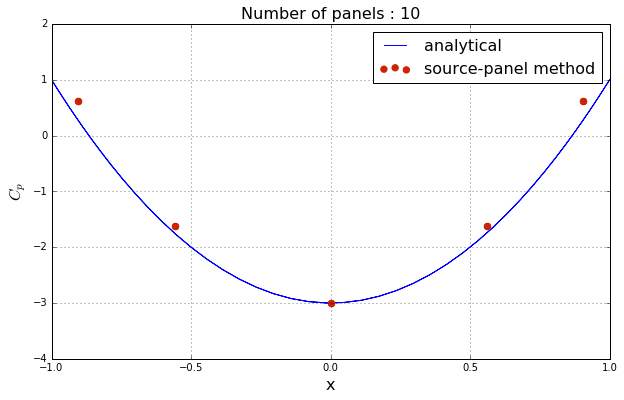

In [17]:
# calculate the analytical surface pressure coefficient
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);


Challenge task